In [48]:
import pandas as pd
import numpy as np
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split

train = pd.read_excel("/data/p_dsi/teams2023/team1/train_data.xlsx")
test = pd.read_excel("/data/p_dsi/teams2023/team1/test_data.xlsx")

# merge the two dataframes
train['train'] = 1
test['train'] = 0
orig_data = pd.concat([train, test], axis=0).drop('phone model', axis=1)

## import wmape functuon 
from helper_functions.ipynb

In [6]:
!pip install ipynb
from ipynb.fs.full.helper_functions import wmape

Defaulting to user installation because normal site-packages is not writeable


## Data Prep

In [49]:
data = orig_data.copy()

data = data.set_index('weeks_monday')
data = pd.get_dummies(data, columns=['phone color'], prefix = ['phone color'])
data.head()

train = data[data['train'] == 1].drop(['train'], axis=1)
test = data[data['train'] == 0].drop(['train'], axis=1)

x_train = train.drop(['claim'], axis=1)
y_train = train['claim']

x_test = test.drop(['claim'], axis=1)
y_test = test['claim']

In [16]:
train.shape, test.shape, x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1205, 23), (46, 23), (1205, 21), (1205,), (46, 21), (46,))

#### split the train and validation data

In [20]:
# validation set:
vali_time = ['2022-02-14','2022-02-21', '2022-02-28', '2022-03-07', '2022-03-14', '2022-03-21', '2022-03-28', '2022-04-04']  

vali = train.loc[train.index.isin(vali_time)]
train_temp = train.loc[~train.index.isin(vali_time)]

x_train_temp = train_temp.drop(['claim'], axis=1)
y_train_temp = train_temp['claim']

x_vali = vali.drop(['claim'], axis=1)
y_vali = vali['claim']

vali.shape, train_temp.shape

((61, 22), (1144, 22))

## manually tune the RF tree

### n_estimators:  20

the number of decision trees that are constructed in the forest

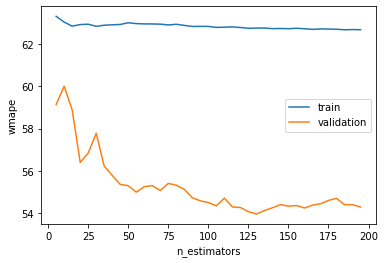

In [21]:
n_estimators = np.arange(5, 200, 5)
train_wmape = []
vali_wmape = []

for n in n_estimators:
    model = RandomForestRegressor(n_estimators=n, min_samples_split = 32, max_depth = 8, random_state=42)
    model.fit(x_train_temp, y_train_temp)
    
    y_vali_pred = model.predict(x_vali)
    y_vali_fit = model.predict(x_train_temp)

    train_wmape.append(wmape(y_train_temp, y_vali_fit))
    vali_wmape.append(wmape(y_vali, y_vali_pred))


# plot the train_wmape and vali_wmape against n_estimators
plt.plot(n_estimators, train_wmape, label='train')
plt.plot(n_estimators, vali_wmape, label='validation')
plt.xlabel('n_estimators')
plt.ylabel('wmape')
plt.legend()
plt.show()

### max_depth:  8

maximum depth of the decision trees. A deeper tree can better fit the training data, but it can also lead to overfitting. Setting a lower value of max_depth can prevent overfitting, while a higher value can lead to better accuracy.

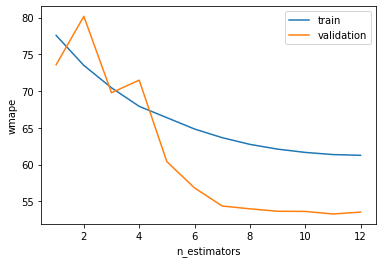

In [22]:
# from 10 to 200 with step 10
max_depth = np.arange(1, 13, 1)
train_wmape = []
vali_wmape = []

for md in max_depth:
    model = RandomForestRegressor(n_estimators=130, min_samples_split = 32, max_depth = md, random_state=42)
    model.fit(x_train_temp, y_train_temp)
    
    y_vali_pred = model.predict(x_vali)
    y_vali_fit = model.predict(x_train_temp)

    train_wmape.append(wmape(y_train_temp, y_vali_fit))
    vali_wmape.append(wmape(y_vali, y_vali_pred))

# plot the train_wmape and vali_wmape against n_estimators
plt.plot(max_depth, train_wmape, label='train')
plt.plot(max_depth, vali_wmape, label='validation')
plt.xlabel('n_estimators')
plt.ylabel('wmape')
plt.legend()
plt.show()

### min_samples_split:  2

the minimum number of samples required to split an internal node. A higher value can prevent overfitting

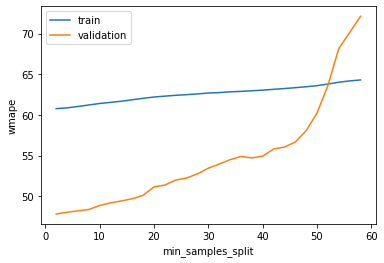

In [23]:
# from 10 to 200 with step 10
min_samples_split = np.arange(2, 60, 2)
train_wmape = []
vali_wmape = []

for mss in min_samples_split:
    model = RandomForestRegressor(n_estimators=130, min_samples_split = mss, max_depth= 8, random_state=42)
    model.fit(x_train_temp, y_train_temp)
    
    y_vali_pred = model.predict(x_vali)
    y_vali_fit = model.predict(x_train_temp)

    train_wmape.append(wmape(y_train_temp, y_vali_fit))
    vali_wmape.append(wmape(y_vali, y_vali_pred))

# plot the train_wmape and vali_wmape against n_estimators
plt.plot(min_samples_split, train_wmape, label='train')
plt.plot(min_samples_split, vali_wmape, label='validation')
plt.xlabel('min_samples_split')
plt.ylabel('wmape')
plt.legend()
plt.show()

### train and fit RF model
n_estimators=20, min_samples_split = 2, max_depth = 8, random_state=42

In [27]:
model = RandomForestRegressor(random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_train_fit = model.predict(x_train)

#calculate the rmse
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
rmse

17.313403916181677

In [28]:
print("test WMAPE: {:.2f}%".format(wmape(y_test, y_pred)))
print("train WMAPE: {:.2f}%".format(wmape(y_train, y_train_fit)))

test WMAPE: 80.48%
train WMAPE: 55.30%


### Transform the dataframe for plotting

In [29]:
# add the y_train and y_pred to x_train as 2 new columns 
x_test['pred'] = y_pred
x_test['claim'] = y_test
x_train['pred'] = y_train_fit
x_train['claim'] = y_train

plot_df = pd.concat([x_train, x_test])

# convert ['phone color_black': 'phone color_white'] columns to original categorical columns
plot_df['phone color'] = plot_df[['phone color_black', 'phone color_blue', 'phone color_gold', 'phone color_graphite', 'phone color_gray','phone color_green', 'phone color_midnight', 'phone color_pink','phone color_purple', 'phone color_red', 'phone color_silver', 'phone color_starlight','phone color_white']].idxmax(axis=1)
plot_df.drop(['phone color_black', 'phone color_blue', 'phone color_gold', 'phone color_graphite', 'phone color_gray','phone color_green', 'phone color_midnight', 'phone color_pink','phone color_purple', 'phone color_red', 'phone color_silver', 'phone color_starlight','phone color_white'], axis=1, inplace=True)

plot_df

,phone size,generation,week_of_month,month,year,weeks_since_release,is_holiday,day,pred,claim,phone color
weeks_monday,,,,,,,,,,,
2021-08-02,128,12,1,8,2021,37,0,2,21.855000,14,phone color_black
2021-08-09,128,12,2,8,2021,38,0,9,44.810000,43,phone color_black
2021-08-16,128,12,3,8,2021,39,0,16,54.580000,57,phone color_black
2021-08-23,128,12,4,8,2021,40,0,23,63.180000,65,phone color_black
2021-08-30,128,12,5,8,2021,41,0,30,59.920000,59,phone color_black
...,...,...,...,...,...,...,...,...,...,...,...
2023-02-06,512,14,1,2,2023,20,0,6,5.815000,1,phone color_white
2023-02-06,128,14,1,2,2023,20,0,6,18.010000,71,phone color_black
2023-02-06,128,14,1,2,2023,20,0,6,8.500000,50,phone color_gold


#### group storage size columns

In [30]:
# group by the pred and claim by phone size, generation, week_of_month, month, year, weeks_since_release, do not aggregate the pred and claim columns
new_df = plot_df.reset_index()
new_df = plot_df.groupby(['generation', 'weeks_monday'])['pred', 'claim'].sum()
new_df = new_df.reset_index()
new_df.head()

/tmp/ipykernel_116496/1102965894.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  new_df = plot_df.groupby(['generation', 'weeks_monday'])['pred', 'claim'].sum()


,generation,weeks_monday,pred,claim
0,12,2021-06-28,486.446929,422
1,12,2021-07-05,1022.408833,1017
2,12,2021-07-12,1029.318476,1045
3,12,2021-07-19,1094.526429,1144
4,12,2021-07-26,1159.366762,1157


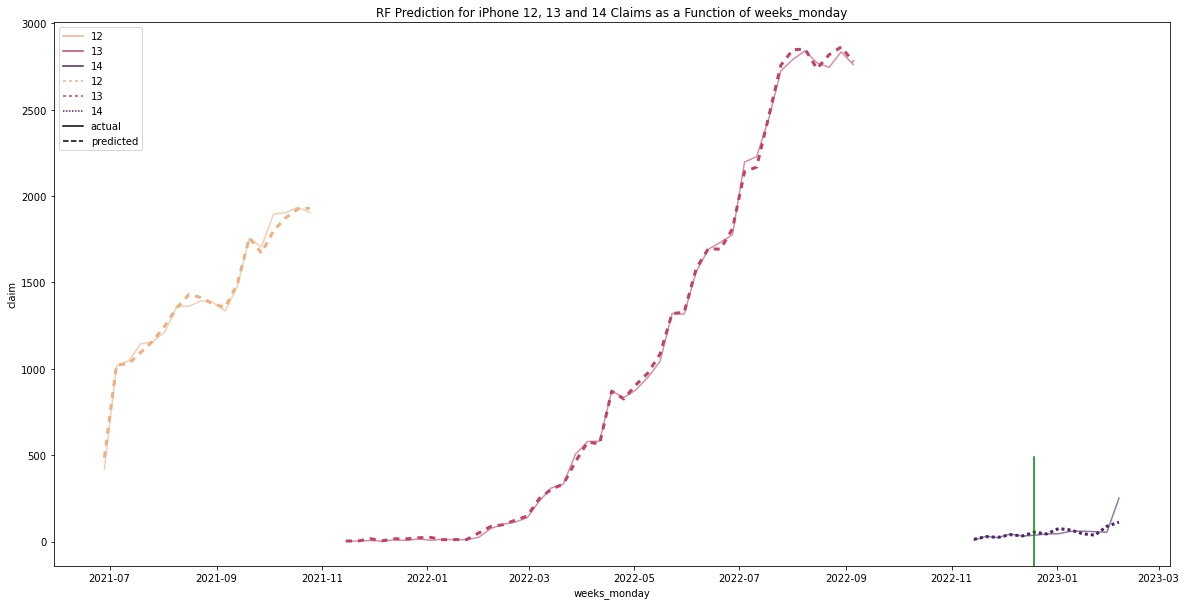

In [32]:
# plot the random forest results for both the actual and predicted values, x-axis is the weeks_monday and y-axis is the claim and pred for each phone model
# the line is the actualvalue and the dashes line is the  predicted value 
# use the same dashed style for all the generations
palette = sns.color_palette("flare", as_cmap=True)

fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x="weeks_monday", y="claim", hue="generation", data=new_df, palette=palette, ax=ax, alpha=0.6)
sns.lineplot(x="weeks_monday", y="pred", hue="generation", data=new_df, palette=palette, ax=ax, style= "generation", dashes=[(2, 2), (2, 2), (1, 1)], linewidth = 3)

# add another legend to show that the dashed line is the actual value and the solid line is the predicted value
ax.plot([],[], label='actual', color = 'black')
ax.plot([],[], linestyle='--', label='predicted', color = 'black')
# add a title to the plot
ax.set_title('RF Prediction for iPhone 12, 13 and 14 Claims as a Function of weeks_monday')
# add a verticle line at '2023-01-02' with a hight of 1000
plt.axvline(x=datetime.datetime.strptime('2022-12-19', '%Y-%m-%d'), ymin=0, ymax=0.2, color='g')

plt.legend(loc='upper left')
plt.show()

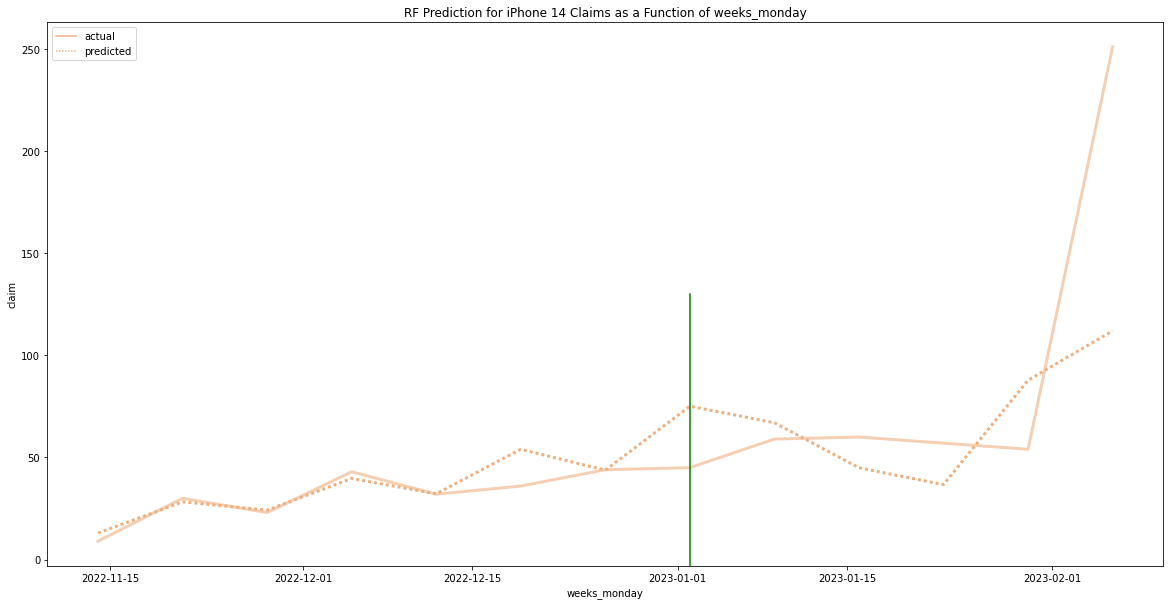

In [33]:
new_df_14 = new_df[new_df['generation'] == 14]

# palette = sns.color_palette("flare", as_cmap=True)

fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x="weeks_monday", y="claim", hue="generation", data=new_df_14, palette=palette, ax=ax, alpha=0.6, linewidth = 3)
sns.lineplot(x="weeks_monday", y="pred", hue="generation", data=new_df_14, palette=palette, ax=ax, style= "generation", dashes=[(1,1)], linewidth = 3)

# change the label text on legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['actual', 'predicted'])

# add a title to the plot
ax.set_title('RF Prediction for iPhone 14 Claims as a Function of weeks_monday')
# add a verticle line at x = 44 with a hight of 80
plt.axvline(x=datetime.datetime.strptime('2023-01-02', '%Y-%m-%d'), ymin=0, ymax=0.5, color='g')

plt.show()

## predict the following 11 weeks for iphone 14

### create the prediction df
In this section, we create a dataframe for preditcting the following 11 weeks (i.e. from 2023-02-13 to 2023-04-24). 

1. create a df for the all the time features, including all the date, weeks_since_release and is_holiday, which is 11 columns
2. create a 3 row 1 column data frame to store all the iphone 14 size.
3. create the one-hot color columns. we first get and one-hot encoded all the iphone 14 colors( 7 in total) and then add the rest colors all filled with 0s after cross joined with the other dfs. 

We cross join the 3 dataframes to get the final prediction data frame, then feed the dataframe in the model to get the prediction. In this case, the final dataframe should have 11x3x7 = **231** rows

In [34]:
tmpdf = plot_df[plot_df['generation'] == 14].groupby(['generation', 'weeks_since_release'])['pred', 'claim'].sum()   
tmpdf = tmpdf.reset_index()
tmpdf

/tmp/ipykernel_116496/1730498425.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmpdf = plot_df[plot_df['generation'] == 14].groupby(['generation', 'weeks_since_release'])['pred', 'claim'].sum()


,generation,weeks_since_release,pred,claim
0,14,8,12.990000,9
1,14,9,28.260000,30
2,14,10,24.199333,23
3,14,11,39.710000,43
4,14,12,32.210000,32
5,14,13,54.008667,36
6,14,14,43.765333,44
7,14,15,75.085833,45
8,14,16,66.995000,59
9,14,17,44.958000,60


#### create the size column and other time featuers

In [62]:
# create a new dataframe called pred_next11, which has the same columns as the tmpdf, but the weeks_since_release goes from 21 to 26
pred_next11 = tmpdf.sort_values(by=['weeks_since_release'], ascending=False).copy().drop(['pred', 'claim'], axis=1)
# just leave the first 11 rows
pred_next11 = pred_next11.iloc[0:11]
# reset the index
pred_next11 = pred_next11.sort_values(by=['weeks_since_release']).reset_index(drop=True)

# each weeks_since_release and week_of_month add 11
pred_next11['weeks_since_release'] = pred_next11['weeks_since_release'] + 11
pred_next11['month'] = [2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4]
pred_next11['week_of_month'] = [2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4]
pred_next11['is_holiday'] = [0]*11
pred_next11['day'] = [13, 20, 27, 6, 13, 20, 27, 3, 10, 17, 24]
pred_next11['year'] = [2023]*11
pred_next11

#### size column
ip14size = data.loc[data['generation']==14, 'phone size'].unique()
ip14size
ip14size_df = pd.DataFrame(ip14size)
ip14size_df.columns = ['phone size']
ip14size_df

,phone size
0,128
1,256
2,512


#### color columns

In [63]:
ip14color = orig_data.loc[orig_data['generation']==14, 'phone color'].unique()
ip14color_df = pd.DataFrame(ip14color)
ip14color_df.columns = ['phone color']


# one hot encode the phone 14 colors
ip14color_df = pd.get_dummies(ip14color_df, columns=['phone color'])

# for each column in ip14color_df cross join with ip14size_df
ip14color_df = ip14color_df.assign(key=1)
ip14size_df = ip14size_df.assign(key=1)
ip14color_size_df = ip14color_df.merge(ip14size_df, on='key').drop('key', 1)
print("# of all iphone14 colors:", ip14color_size_df.shape)

#  add other colors that ip14 does not have
ip14color_size_df[['phone color_graphite', 'phone color_gray', 'phone color_green', 'phone color_midnight', 'phone color_pink','phone color_starlight']]=[[0]*6]*21
ip14color_size_df.shape

# of all iphone14 colors: (21, 8)


/tmp/ipykernel_116496/1547998054.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  ip14color_size_df = ip14color_df.merge(ip14size_df, on='key').drop('key', 1)


(21, 14)

#### final prediction dataframe


In [64]:
# cross join the pred_next11 and ip14color_size_df
pred_next11 = pred_next11.assign(key=1)
ip14color_size_df = ip14color_size_df.assign(key=1)
pred_next11_ip14 = pred_next11.merge(ip14color_size_df, on='key').drop('key', 1)

# match the column order of the pred_next11_ip14 with x_train
pred_next11_ip14 = pred_next11_ip14[train.drop(['claim'], axis=1).columns]
pred_next11_ip14

/tmp/ipykernel_116496/4179027119.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  pred_next11_ip14 = pred_next11.merge(ip14color_size_df, on='key').drop('key', 1)


,phone size,generation,week_of_month,month,year,weeks_since_release,is_holiday,day,phone color_black,phone color_blue,...,phone color_graphite,phone color_gray,phone color_green,phone color_midnight,phone color_pink,phone color_purple,phone color_red,phone color_silver,phone color_starlight,phone color_white
0,128,14,2,2,2023,21,0,13,1,0,...,0,0,0,0,0,0,0,0,0,0
1,256,14,2,2,2023,21,0,13,1,0,...,0,0,0,0,0,0,0,0,0,0
2,512,14,2,2,2023,21,0,13,1,0,...,0,0,0,0,0,0,0,0,0,0
3,128,14,2,2,2023,21,0,13,0,0,...,0,0,0,0,0,0,0,0,0,1
4,256,14,2,2,2023,21,0,13,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,256,14,4,4,2023,31,0,24,0,0,...,0,0,0,0,0,0,0,0,0,0
227,512,14,4,4,2023,31,0,24,0,0,...,0,0,0,0,0,0,0,0,0,0
228,128,14,4,4,2023,31,0,24,0,0,...,0,0,0,0,0,0,0,1,0,0
229,256,14,4,4,2023,31,0,24,0,0,...,0,0,0,0,0,0,0,1,0,0


## prediction

In [65]:
#use the df to predict the next 11 weeks
pred_next11_ip14['pred'] = model.predict(pred_next11_ip14)

# reverse back the one hot encoding for the phone color from ['phone color_black': 'phone color_white']
pred_next11_ip14['phone color'] = pred_next11_ip14.iloc[:, 7:20].idxmax(axis=1)
pred_next11_ip14['phone color'] = pred_next11_ip14['phone color'].str.replace('phone color_', '')

# drop the one hot encoded columns
pred_next11_ip14 = pred_next11_ip14.drop(pred_next11_ip14.iloc[:, 7:20], axis=1)
pred_next11_ip14.head()

,phone size,generation,week_of_month,month,year,weeks_since_release,is_holiday,phone color_white,pred,phone color
0,128,14,2,2,2023,21,0,0,18.180,day
1,256,14,2,2,2023,21,0,0,9.920,day
2,512,14,2,2,2023,21,0,0,8.570,day
3,128,14,2,2,2023,21,0,1,14.370,day
4,256,14,2,2,2023,21,0,1,8.475,day


In [66]:
# pred claims in general
res = pred_next11_ip14.groupby(['generation', 'week_of_month','month','weeks_since_release'])['pred'].sum()
res = res.reset_index()
res.sort_values(['weeks_since_release'], ascending=True)

,generation,week_of_month,month,weeks_since_release,pred
2,14,2,2,21,377.983333
5,14,3,2,22,393.746667
8,14,4,2,23,433.595333
0,14,1,3,24,429.876143
3,14,2,3,25,478.787000
6,14,3,3,26,529.241667
9,14,4,3,27,562.949000
1,14,1,4,28,557.472690
4,14,2,4,29,549.118262
7,14,3,4,30,502.604738
